In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

[ Info: Precompiling CUDA [052768ef-5323-5732-b1bb-66c8b64840ba] (cache misses: mismatched flags (4))
[ Info: Precompiling AtomixCUDAExt [13011619-4c7c-5ef0-948f-5fc81565cd05] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling LuxCUDA [d0bbae9a-e099-4d5b-a835-1c6931763bda] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling ComponentArrays [b0b7db55-cfe3-40fc-9ded-d10e2dbeff66] (cache misses: mismatched flags (4))
[ Info: Precompiling ChainRulesCoreExt [eae2faf6-b232-58cb-a410-7764fda2830c] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling ArrayInterfaceGPUArraysCoreExt [f5566fad-042a-5915-b3b1-71de67883923] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling ArrayInterfaceSparseArraysExt [df319534-c31f-52ad-82d4-403d3787952e] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling ArrayInterfaceCUDAExt [f7858

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling MLUtils [f1d291b0-491e-4a28-83b9-f70985020b54] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling BangBangStructArraysExt [d139770a-8b79-56c4-91f8-7273c836fd96] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling BangBangDataFramesExt [d787bcad-b5c5-56bb-adaa-6bfddb178a59] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling SciMLBaseMLStyleExt [54891929-e0db-55d3-b096-c0f3ec60df6b] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling DistributionsTestExt [ffbe0ea5-a612-5ff7-aaf5-cac02eef3019] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling TransducersDataFramesExt [cefb4096-3352-5e5f-8501-71f024082a88] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling TransducersLazyArraysExt [cdbecb60-77cf-500a-86c2-8d8bbf22df88] (cache misses: wrong dep version 

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
# Circle: returns true if (px, py) is inside the circle of radius r centered at (cx, cy)
circle_mask(px, py, cx, cy, r) = (px - cx)^2 + (py - cy)^2 <= r^2

# Cross: returns true if (px, py) is within the cross arms centered at (cx, cy) with arm length size and thickness t
function cross_mask(px, py, cx, cy, size, t)
    half = size / 2
    # Horizontal arm
    in_h = abs(py - cy) <= t/2 && abs(px - cx) <= half
    # Vertical arm
    in_v = abs(px - cx) <= t/2 && abs(py - cy) <= half
    return in_h || in_v
end

# Rasterize a random shape to a grid array
function raster_random_shape(rng::AbstractRNG; canvas_size=10, grid_size=128, cross_thickness=0.2, noise_level=0.025)
    shape_type = rand(rng, ["cross", "circle"])
    vmap = Dict("cross" => 1, "circle" => 2)
    x = rand(rng) * canvas_size
    y = rand(rng) * canvas_size
    size = (canvas_size / 5)
    t = cross_thickness * size

    # Set up grid coordinates (center of each pixel)
    xs = range(0, canvas_size, length=grid_size)
    ys = range(0, canvas_size, length=grid_size)
    img = zeros(Float32, grid_size, grid_size, 1)

    for j in 1:grid_size, i in 1:grid_size
        px, py = xs[i], ys[j]
        if shape_type == "circle"
            img[j, i, 1] = circle_mask(px, py, x, y, size/2) ? 1 : 0
        else
            img[j, i, 1] = cross_mask(px, py, x, y, size, t) ? 1 : 0
        end
    end

    noise = noise_level .* abs.(randn(rng, Float32, grid_size, grid_size, 1))
    img .= clamp.(img .+ noise, 0.0f0, 1.0f0)

    return img, vmap[shape_type]
end

raster_random_shape (generic function with 1 method)

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [9]:
args = Args(batchsize = 128, epochs = 25)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [10]:
function generate_dataset(rng::AbstractRNG, n::Int, args::Args, noise_level::Real = 0.05)
    data = [raster_random_shape(rng, noise_level=noise_level) for i in 1:n];
    x = stack([d[1] for d in data]);
    y = onehotbatch(stack([d[2] for d in data]), 1:2);
    loader = DataLoader((x, y), batchsize = args.batchsize)
    return loader
end

generate_dataset (generic function with 2 methods)

In [11]:
noise_level = 0.00

0.0

In [12]:
train_loader = generate_dataset(rng, 10000, args, noise_level)

79-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [13]:
x0, y0 = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 1 1 … 1 1])

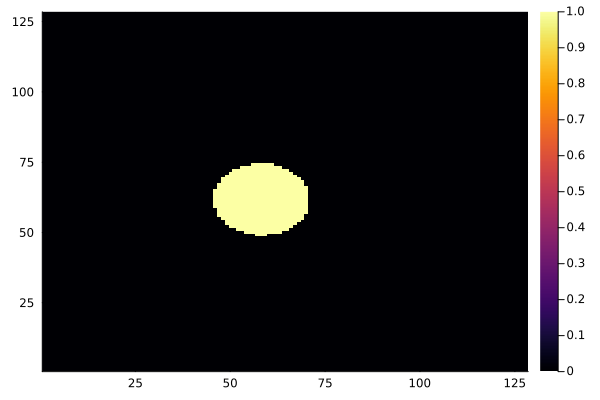

In [14]:
heatmap(x0[:,:,1,1])

In [15]:
y0[:,1]

2-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1

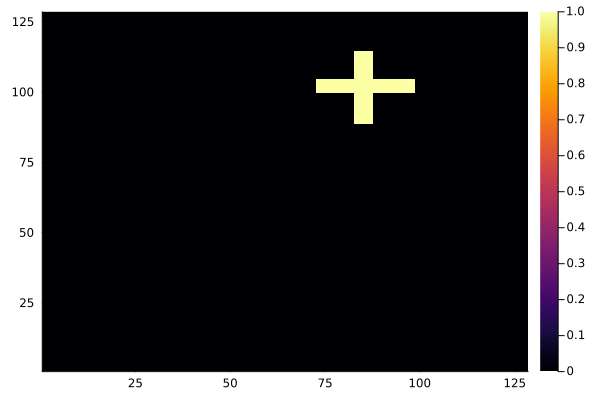

In [16]:
heatmap(x0[:,:,1,10] |> cdev)

In [17]:
y0[:,10]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

In [18]:
gu = glorot_uniform

glorot_uniform (generic function with 8 methods)

In [19]:
l1 = Chain(Conv((32,32), 1=>3, relu, pad=(1,1), init_weight=gu),)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
)         # Total: 3_075 parameters,
          #        plus 0 states.

In [20]:
pc1, st1 = Lux.setup(args.rng, l1) .|> gdev

((layer_1 = (weight = Float32[-0.0034841762 -0.0016821366 … -0.020128593 0.01660142; -0.024986744 -0.036207687 … 0.0072304974 -0.0015313312; … ; 0.004218169 0.027183954 … 0.019954098 -0.014109451; 0.009388219 0.03333457 … 0.03558682 -0.038266618;;;; -0.0049630613 0.024682323 … 0.021205783 0.0053131534; 0.0073187915 0.0011486764 … -0.037837457 -0.0050171455; … ; 0.026581643 -0.005310548 … 0.014991229 0.0014630575; -0.03620977 0.028937288 … -0.022090621 -0.015945118;;;; 0.029828647 -0.02825459 … 0.027455455 0.03651365; 0.024347693 -0.0010327105 … -0.010969956 -0.026191402; … ; -0.013010105 0.0060414975 … 0.034873445 -0.03129835; -0.03079045 0.032877844 … 0.017425781 0.023929806], bias = Float32[-0.013976701, 0.01387392, 0.015629027]),), (layer_1 = NamedTuple(),))

In [21]:
s1, _ = l1(x0 |> gdev, pc1, st1) |> cdev

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.013873909 0.013873906 … 0.013873915 0.013873915; 0.013873915 0.013873912 … 0.013873919 0.013873914; … ; 0.013873923 0.0138739245 … 0.013873928 0.01387393; 0.013873913 0.013873914 … 0.013873914 0.013873918;;; 0.015629021 0.015629018 … 0.01562902 0.015629016; 0.015629033 0.01562903 … 0.015629025 0.015629023; … ; 0.015629033 0.015629034 … 0.015629023 0.015629025; 0.015629038 0.01562904 … 0.015629012 0.015629012;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.08337694 0.0; 0.0 0.0 … 0.11808326 0.015774703;;; 0.013873933 0.013873928 … 0.013873928 0.0138739245; 0.013873922 0.013873923 … 0.013873906 0.013873909; … ; 0.013873933 0.013873882 … 0.0 0.0; 0.013873936 0.0138738975 … 0.0 0.0;;; 0.015629036 0.015629036 … 0.015629046 0.015629044; 0.015629018 0.015629018 … 0.015629038 0.015629034; … ; 0.015629046 0.015629055 … 0.0 0.0; 0.015629025 0.015629055 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 …

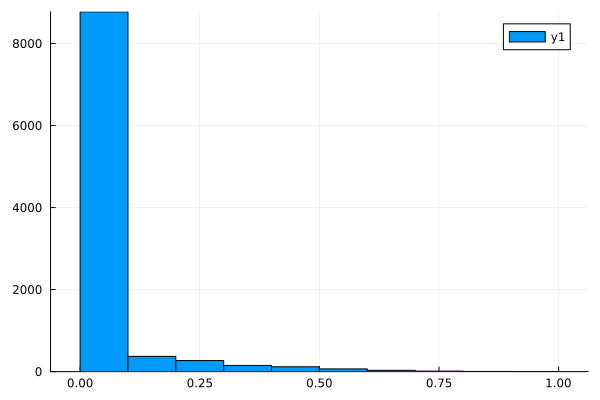

In [22]:
histogram(vec(s1[:,:,1,1]))

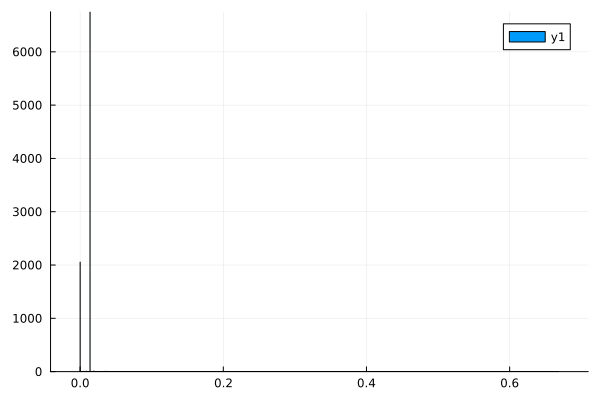

In [23]:
histogram(vec(s1[:,:,2,1]))

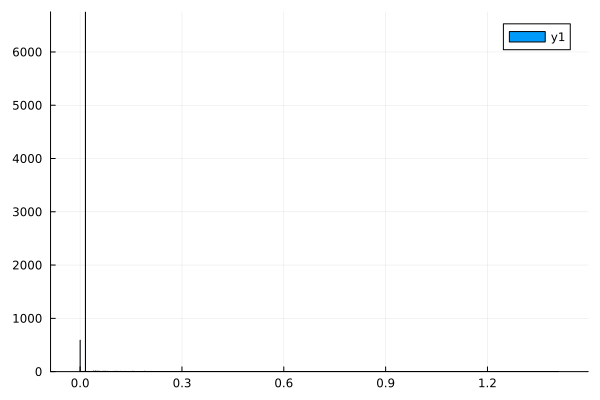

In [24]:
histogram(vec(s1[:,:,3,1]))

In [25]:
gu = glorot_uniform
model = Chain(Conv((32,32), 1=>3, relu, pad=(1,1), init_weight=gu),
            MaxPool((2,2)),
            Dropout(0.3),

            Conv((16,16), 3=>1, relu, pad=(1,1), init_weight=gu),
            MaxPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),

            Dense(324 => 16, relu, init_weight=gu),
            Dense(16 => 2, init_weight=gu),
            softmax)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Dropout(0.3),
    layer_4 = Conv((16, 16), 3 => 1, relu, pad=1),  # 769 parameters
    layer_5 = MaxPool((2, 2)),
    layer_6 = FlattenLayer{Nothing}(nothing),
    layer_7 = Dropout(0.4),
    layer_8 = Dense(324 => 16, relu),             # 5_200 parameters
    layer_9 = Dense(16 => 2),                     # 34 parameters
    layer_10 = WrappedFunction(softmax),
)         # Total: 9_078 parameters,
          #        plus 4 states.

In [26]:
ps, st = Lux.setup(rng, model) .|> gdev

((layer_1 = (weight = Float32[0.027360117 0.004072884 … -0.01807847 -0.032759733; -0.010413798 0.034778245 … 0.035285465 0.029700717; … ; 0.013936236 0.016096503 … 0.0068119536 -0.0050979843; 0.024638558 -0.03759801 … 0.01713775 -0.0017146537;;;; -0.009451081 -0.035764314 … 0.03800448 -0.028433735; 0.019742338 -0.01503904 … -0.029003553 0.019710401; … ; 0.02394051 -0.0042611933 … -0.03424003 -0.012044286; 0.022216065 -0.0075315284 … -0.032815184 -0.00018849639;;;; 0.027850054 -0.01748911 … -0.017920448 -0.0366432; 0.0046768216 0.037568145 … 0.030030968 0.01817868; … ; -0.0033469764 0.0062101926 … -0.024179874 0.034493655; 0.036317687 0.015781939 … -0.023384972 0.010362706], bias = Float32[0.006960854, 0.019366581, -0.0013264604]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.022960067 0.056717463 … -0.07555596 -0.0018904388; 0.02469069 0.007871415 … -0.062392905 0.065183885; … ; 0.030703621 -0.024193693 … 0.020592524 -0.061125997; 0.009805854 0.0667566

In [27]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y)
end

loss_function (generic function with 1 method)

In [28]:
x0 = x0 |> gdev
y0 = y0 |> gdev

2×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.DeviceMemory}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅
 1  1  1  1  1  1  ⋅  1  1  ⋅  ⋅  1  1     1  1  1  ⋅  1  ⋅  1  ⋅  1  1  1  1

In [29]:
l, gs = withgradient(p -> loss_function(x0, y0, model, p, st), ps)

(val = 0.74465835f0, grad = ((layer_1 = (weight = Float32[-0.00031735655 -0.004736241 … 0.005442784 0.008125611; 0.0056119002 -0.0029024906 … 0.0039036295 0.012330126; … ; 0.03143771 0.030890636 … -0.01479481 -0.015417209; 0.026754122 0.03126192 … -0.012420882 -0.0105061345;;;; 0.0015436199 -5.021831f-5 … -0.006225123 -0.0038962353; 0.0022090762 -0.00051762466 … 0.0005807119 0.0035410183; … ; 0.031185161 0.03207282 … 2.0275926f-5 0.0014962004; 0.028861929 0.027719885 … 0.0023569549 0.000900847;;;; 0.019852744 0.019056613 … 0.012184848 0.010110129; 0.025444191 0.025617108 … 0.010261407 0.0145135; … ; 0.019008175 0.02386566 … -0.0033884193 -0.0040012756; 0.008461395 0.015195012 … 0.0031267363 -0.0019259171], bias = Float32[-0.11947107, -0.023701668, 0.057811655]), layer_2 = nothing, layer_3 = nothing, layer_4 = (weight = Float32[0.017065717 0.013039952 … 0.008302197 0.019041985; 0.0097308485 0.016293693 … 0.014013748 0.01546679; … ; 0.018543217 0.011356539 … 0.011533804 0.010445906; 0.01

In [30]:
losses, pst, stt = train(model, ps, st, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[0.74465835f0, 0.70535755f0, 0.7380618f0, 0.69517934f0, 0.6979648f0, 0.6983737f0, 0.6886363f0, 0.6982419f0, 0.6925905f0, 0.7067141f0  …  0.010330867f0, 0.010533093f0, 0.009471869f0, 0.009827696f0, 0.01012525f0, 0.011072839f0, 0.00905194f0, 0.010687634f0, 0.023742065f0, 0.006770541f0], (layer_1 = (weight = Float32[0.027398214 -0.013289893 … -0.06521094 -0.12776604; -0.02457138 0.0071610976 … 0.00035794597 -0.05270742; … ; -0.05389901 -0.034408633 … 0.007918051 -0.0044014854; -0.05815214 -0.10033846 … 0.015785374 -0.0043121395;;;; -0.10842632 -0.10270937 … -0.040141888 -0.08394878; -0.02937313 -0.022257254 … -0.102626905 -0.021207536; … ; -0.047573116 -0.06388508 … -0.15604994 -0.10020771; -0.039176106 -0.04872057 … -0.15343384 -0.0884034;;;; 0.0029974224 -0.028633678 … -0.027490716 -0.037459705; -0.007529588 0.0231491 … 0.037282538 0.02723499; … ; -0.02116823 0.019187583 … -0.040065255 0.011880001; -0.0068492116 0.0020184158 … -0.038822006 -0.002106543], bias = Float32[0.009342642, 

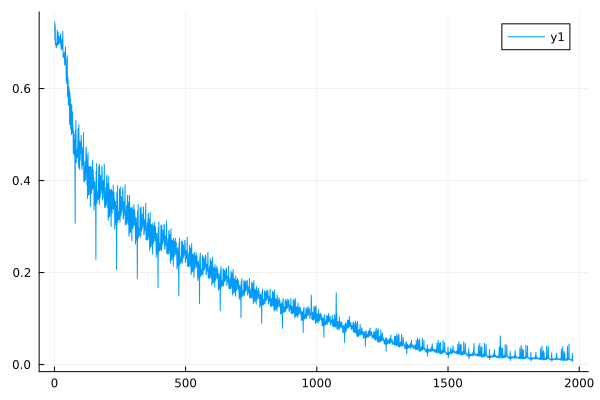

In [31]:
plot(losses)

In [32]:
yh1, _ = model(x0, pst, stt)

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/R8Czx/src/utils.jl:334


(Float32[0.04488808 0.018053545 … 0.024089567 0.022088338; 0.955112 0.9819465 … 0.9759104 0.9779116], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (rng = Xoshiro(0x2f955d8e82784d90, 0x37c0a1868004128c, 0xd24c9de1cb693dbe, 0x87a4e3a74a26e167, 0xc90c4a0730db3f7e), training = Val{true}()), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = (rng = Xoshiro(0x9ff11faf485abe7b, 0xca1961e9c91562a2, 0xbed4c0676c09702e, 0x5e7d760c88443944, 0xc90c4a0730db3f7e), training = Val{true}()), layer_8 = NamedTuple(), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

In [33]:
test_loader = generate_dataset(rng, 1000, args, noise_level)

8-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [34]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        true_labels = onecold(y)
        
        total_correct += sum(pred_labels .== true_labels)
        total_samples += size(x, length(size(x)))
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [35]:
test(model, test_loader, ps, st)

0.525

In [36]:
test(model, test_loader, pst, stt)

0.999

# Replicate with Phasor Architecture

In [37]:
import .PhasorNetworks: LuxParams, ComplexBias, PhasorConv

In [38]:
m1 = Chain(PhasorConv((32, 32), 1 => 3, identity, init_weight = gu),)

Chain(
    layer_1 = PhasorConv(
        layer = Conv((32, 32), 1 => 3, use_bias=false),  # 3_072 parameters
        bias = ComplexBias((1, 1, 3)),            # 6 parameters
    ),
)         # Total: 3_078 parameters,
          #        plus 0 states.

In [39]:
psp, stp = Lux.setup(rng, m1) .|> gdev

((layer_1 = (layer = (weight = Float32[-0.0296829 -0.037275504 … -0.0057642506 0.013133143; 0.028966561 0.00623201 … 0.012438215 0.015952267; … ; -0.022337236 -0.030911818 … 0.024241453 0.0039603994; -0.025618326 0.013320102 … -0.0006018571 0.031183636;;;; -0.001888664 0.017292779 … 0.02359118 -0.007374559; -0.0022908694 0.011594827 … -0.030151622 -0.003959884; … ; 0.026384803 -0.024255762 … -0.019276626 0.033002947; 0.011240396 0.026873628 … -0.029010963 -0.009456939;;;; 0.0013685218 0.01781768 … -0.01889062 -0.01964737; 0.016949732 0.018542662 … 0.010009544 0.036979374; … ; -0.03534447 0.030253472 … 0.0056635053 -0.022602584; 0.028095929 -0.016630888 … 0.0066681975 -0.007702067],), bias = (bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])),), (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),))

In [40]:
psp.layer_1.bias.bias_imag

1×1×3 CuArray{Float32, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 0.0

[:, :, 2] =
 0.0

[:, :, 3] =
 0.0

In [41]:
psp.layer_1.bias.bias_real

1×1×3 CuArray{Float32, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 1.0

[:, :, 2] =
 1.0

[:, :, 3] =
 1.0

In [42]:
import .PhasorNetworks: soft_angle, pi_f32

In [43]:
import ChainRulesCore: ignore_derivatives

In [44]:
yp0, _ = m1(x0, psp, stp) |> cdev;

In [45]:
size(yp0)

(97, 97, 3, 128)

In [46]:
typeof(yp0)

Array{ComplexF32, 4}

In [75]:
typeof(yp0)

Array{ComplexF32, 4}

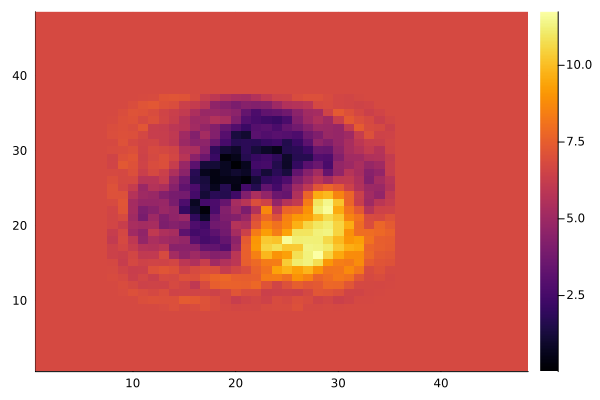

In [74]:
heatmap(abs.(lpnormpool(yp0, 1, (2,2)))[:,:,1,1])

In [48]:
m2 = Chain(LPPool((2,2), p=50.0))

Chain(
    layer_1 = LPPool((2, 2), p=50.0),
)         # Total: 0 parameters,
          #        plus 0 states.

In [49]:
ps2, st2 = Lux.setup(args.rng, m2)

((layer_1 = NamedTuple(),), (layer_1 = NamedTuple(),))

In [50]:
yp1, _ = m2(yp0, ps2, st2)

(ComplexF32[1.7374725f0 + 1.1497141f-15im 1.7374725f0 + 8.436828f-16im … 1.7374725f0 + 9.397092f-16im 1.7374725f0 + 5.0160576f-16im; 1.7374725f0 + 1.2681525f-15im 1.7374725f0 + 1.2673026f-15im … 1.7374725f0 - 2.7475668f-16im 1.7374725f0 + 2.1134815f-16im; … ; 1.7374727f0 + 4.562615f-16im 1.7374727f0 + 3.9665928f-16im … 1.7374725f0 - 5.9955215f-16im 1.7374725f0 - 1.0349961f-16im; 1.7374725f0 + 1.4957949f-15im 1.7374725f0 + 1.3162041f-15im … 1.7374724f0 + 6.299838f-16im 1.7374724f0 + 3.969734f-16im;;; 1.0380472f0 - 2.415314f-15im 1.0380472f0 - 9.759334f-16im … 1.0380472f0 - 4.2572448f-16im 1.0380472f0 - 7.4117003f-16im; 1.0380472f0 - 6.158355f-16im 1.0380472f0 - 4.6103866f-16im … 1.0380472f0 - 6.87179f-16im 1.0380472f0 - 9.250637f-16im; … ; 1.0380472f0 + 1.3863612f-16im 1.0380472f0 + 5.330868f-16im … 1.0380473f0 + 1.3717744f-15im 1.0380472f0 + 1.8507772f-15im; 1.0380472f0 + 6.111239f-17im 1.0380472f0 - 1.2997511f-16im … 1.0380472f0 + 1.4508307f-16im 1.0380472f0 + 5.4915015f-16im;;; 0.416

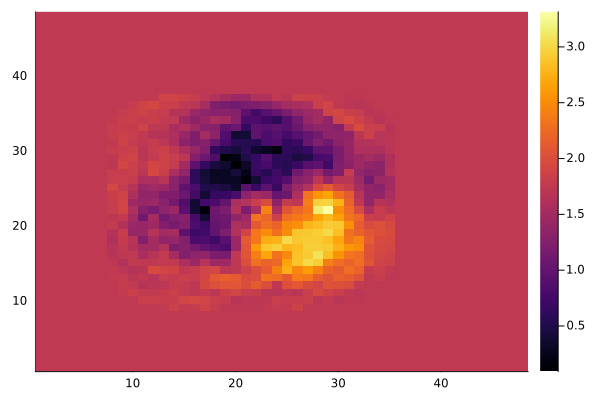

In [51]:
heatmap(abs.(yp1[:,:,1,1]))

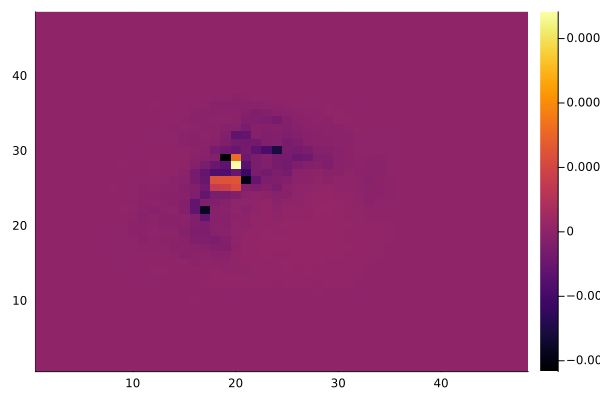

In [52]:
heatmap(angle.(yp1[:,:,1,1]))

In [53]:
struct MinPool <: Lux.AbstractLuxContainerLayer{(:layer)}
    layer::MaxPool
end

# Constructor that takes same args as MaxPool
MinPool(kernel_size; kwargs...) = MinPool(MaxPool(kernel_size; kwargs...))

# Forward pass implementation
function (mp::MinPool)(x, ps, st)
    y, st = mp.layer(-1.0f0 .* x, ps, st)
    return -1.0f0 .* y, st
end

function Lux.initialparameters(rng::AbstractRNG, pool::MinPool)
    st_layer = Lux.initialparameters(rng, pool.layer)
    return st_layer
end

function Lux.initialstates(rng::AbstractRNG, pool::MinPool)
    st_layer = Lux.initialstates(rng, pool.layer)
    return st_layer
end

In [54]:
# p_model = Chain(LayerNorm((128,128,1)),
#             x -> tanh.(x),
#             PhasorConv((32,32), 1=>3, pad=(1,1), complex_to_angle, init_weight=gu, init_bias = nothing),
#             MinPool((2,2)),
#             Dropout(0.3),

#             PhasorConv((16,16), 3=>1, pad=(1,1), complex_to_angle, init_weight=gu, init_bias = nothing),
#             MinPool((2,2)),
#             FlattenLayer(),
#             Dropout(0.4),
            
#             PhasorDense(324 => 16, complex_to_angle, init_weight=gu),
#             PhasorDense(16 => 2, complex_to_angle, init_weight=gu),
#             );

In [64]:
using NNlib: lpnormpool

In [277]:
p_model = Chain(LayerNorm((128,128,1)),
            x -> tanh.(x),
            PhasorConv((32,32), 1=>3, pad=(1,1), soft_angle, init_weight=gu, init_bias = nothing),
            MeanPool((2,2)),
            Dropout(0.3),

            PhasorConv((16,16), 3=>1, pad=(1,1), soft_angle, init_weight=gu, init_bias = nothing),
            MeanPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),
            
            PhasorDense(324 => 324, complex_to_angle, init_weight=gu),
            Codebook(324 => 2),
            );

In [278]:
pps, pst = Lux.setup(rng, p_model) .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;;]), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[0.035489537 -0.025936006 … 0.0035016097 0.035257373; 0.020735076 -0.015394954 … -0.038068652 0.0076546897; … ; -0.022721497 0.016939243 … -0.023006942 0.027487686; 0.011852017 0.03250302 … -0.0144454595 0.0148592945;;;; 0.020324672 -0.009960629 … 0.014484186 0.02554627; 0.03155442 -0.020763634 … 0.008181598 0.028307043; … ; -0.027695512 -0.00717332 … 0.03374554 0.014419699; -0.038150724 0.012007891 … -0.035690363 0.021451056;;;; -0.011914386 -0.031244373 … -0.011753439 0.011587308; 0.023769848 -0.015330353 … 0.010362278 0.033809576; … ; -0.0279445 -0.023730824 … -0.028973993 0.021352053; 0.008590775 -0.03577306 … 0.0116496505 0.011379252],), bias = (bias_real = Float32[0.0;;; 0.0;;; 0.0], bias_imag = Float32[0.0;;;

In [279]:
yhp0, _ = p_model(x0 |> gdev, pps, pst)

(Float32[0.021500507 0.036843795 … 0.018985612 0.049247093; 0.015618229 0.020363048 … 0.006648087 -0.0011118772], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = NamedTuple(), bias = NamedTuple()), layer_4 = NamedTuple(), layer_5 = (rng = Xoshiro(0x32a3bbc4927a376a, 0xee95d07afa140e84, 0x3972e1b8f8f06acc, 0x50b77d2e96e9ee72, 0xc90c4a0730db3f7e), training = Val{true}()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = NamedTuple(), layer_9 = (rng = Xoshiro(0x8c811690fe87d79c, 0xe5448a06909e5322, 0xab24ae5477825da6, 0xbc1ed7c455aa8d9f, 0xc90c4a0730db3f7e), training = Val{true}()), layer_10 = (dense = NamedTuple(), bias = NamedTuple()), layer_11 = NamedTuple()))

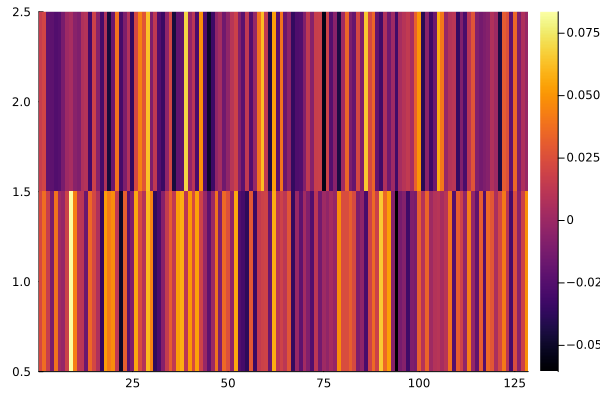

In [280]:
heatmap(yhp0 |> cdev)

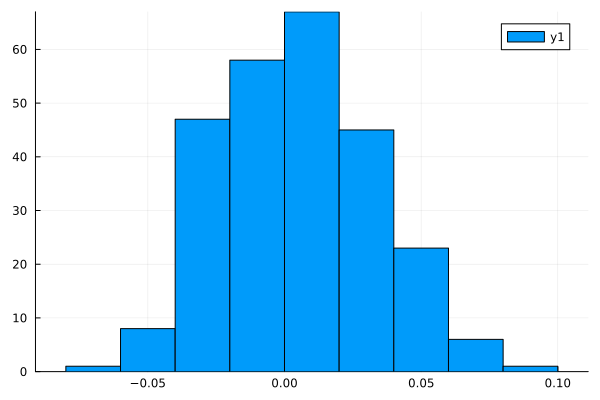

In [281]:
histogram(vec(cdev(yhp0)))

In [282]:
codebook_loss(yhp0, y0) |> mean

0.49611658f0

In [283]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    loss = codebook_loss(y_pred, y, dims=1) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [284]:
l2, gs2 = withgradient(p -> phasor_loss_function(x0, y0, p_model, p, pst), pps)

(val = 0.49611658f0, grad = ((layer_1 = (bias = Float32[5.657624f-7 9.823302f-7 … -1.9011234f-6 -3.2139064f-7; 1.1690788f-6 7.0948045f-7 … 1.3369299f-6 2.7920169f-7; … ; -3.6521124f-7 -1.426947f-6 … 1.9576983f-6 -1.4185521f-6; 1.4713232f-6 2.3271873f-6 … 2.45119f-6 4.9431355f-7;;;;], scale = Float32[-8.398792f-8 -1.4583327f-7 … 2.822019f-7 4.7707083f-8; -1.7353719f-7 -1.0531726f-7 … -1.9845324f-7 -4.1444583f-8; … ; 5.4210634f-8 2.1181843f-7 … -2.9059987f-7 2.1056924f-7; -2.1840341f-7 -3.4544877f-7 … -3.638536f-7 -7.337568f-8;;;;]), layer_2 = nothing, layer_3 = (layer = (weight = Float32[0.00045115897 0.00060525886 … 0.00028866366 -0.0001329818; 0.00057506945 0.0007256635 … 0.0004262838 0.00017852033; … ; 9.2433766f-7 0.00013796939 … 8.706888f-5 0.0007566032; 4.8499205f-5 0.00019377295 … 0.0002173977 0.0008466563;;;; -0.0014762757 -0.0021518199 … -0.00081082876 -0.001494681; -0.001176601 -0.0019087608 … -0.00067123165 -0.0018115982; … ; -0.002787426 -0.002283779 … 0.00051288656 0.000313

In [298]:
args = Args(batchsize = 128, epochs = 40, lr=0.0001)

Args(0.0001, 128, 40, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [299]:
p_losses, ppst, pstp = train(p_model, pps, pst, train_loader, phasor_loss_function, args, optimiser=Optimisers.RMSProp)

[ Info: Training on CUDA GPU


(Any[0.49611658f0, 0.4920305f0, 0.48933813f0, 0.4807925f0, 0.48819315f0, 0.46697763f0, 0.47561386f0, 0.47432142f0, 0.47285154f0, 0.46889108f0  …  0.1460128f0, 0.1335888f0, 0.12074304f0, 0.12438393f0, 0.11216885f0, 0.13464765f0, 0.12569696f0, 0.12978916f0, 0.112824306f0, 0.13869593f0], (layer_1 = (bias = Float32[0.0066816765 -0.014991373 … 0.038550153 0.043326594; 0.014690836 -0.011632611 … 0.06799918 0.0633073; … ; 0.019090781 0.078067854 … 0.011702711 -0.038117465; 0.004727869 0.049172133 … 0.006564944 -0.019554162;;;;], scale = Float32[0.9937445 1.0147057 … 0.96288943 0.9587112; 0.986226 1.0112412 … 0.9334648 0.93840104; … ; 0.981271 0.9232725 … 0.98941785 1.0335758; 0.99472475 0.95233476 … 0.99467635 1.0154027;;;;]), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[0.0137994345 -0.030795272 … -0.0051751733 0.01526649; 0.0021376386 -0.018559817 … -0.045887314 -0.011301244; … ; -0.031814955 0.013475797 … -0.002662909 0.044806402; -0.009158068 0.012384934 … 0.0021573913 0.0

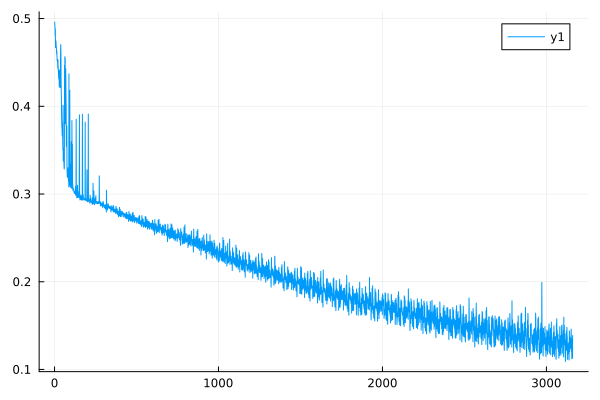

In [300]:
plot(p_losses)

In [301]:
yhp1, _ = p_model(x0, ppst, pstp)

(Float32[0.22506897 0.13068795 … 0.19156386 0.17200188; 0.43420035 0.601234 … 0.60215074 0.6004103], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = NamedTuple(), bias = NamedTuple()), layer_4 = NamedTuple(), layer_5 = (rng = Xoshiro(0x32a3bbc4927a376a, 0xee95d07afa140e84, 0x3972e1b8f8f06acc, 0x50b77d2e96e9ee72, 0xc90c4a0730db3f7e), training = Val{true}()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = NamedTuple(), layer_9 = (rng = Xoshiro(0x8c811690fe87d79c, 0xe5448a06909e5322, 0xab24ae5477825da6, 0xbc1ed7c455aa8d9f, 0xc90c4a0730db3f7e), training = Val{true}()), layer_10 = (dense = NamedTuple(), bias = NamedTuple()), layer_11 = NamedTuple()))

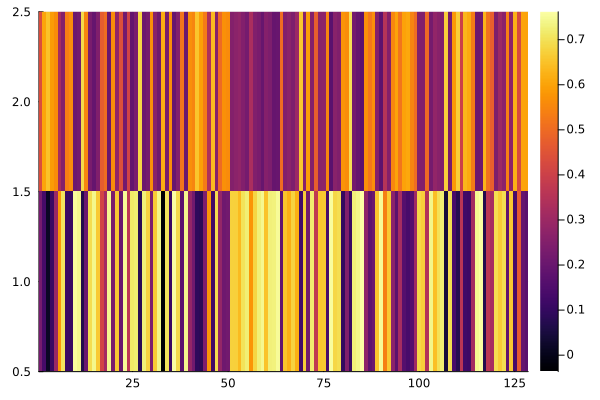

In [302]:
heatmap(yhp1 |> cdev)

In [303]:
xs = -1.0:0.01:1.0 .* pi;

In [304]:
distances = vec(cdev(1.0 .* y0) .- (cdev(yhp1)));

In [305]:
xs = 0.0:0.01:2.0

0.0:0.01:2.0

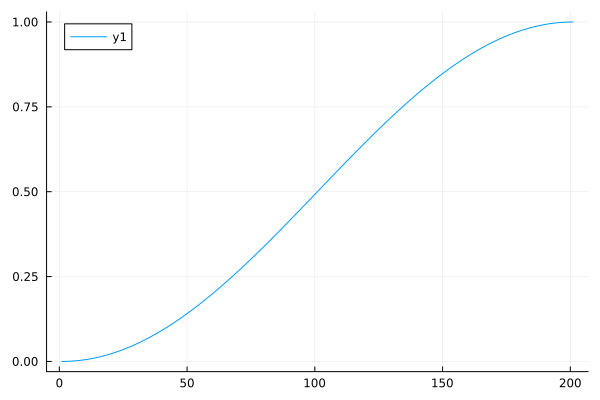

In [306]:
plot(sin.(pi/4 .* xs) .^ 2.0)

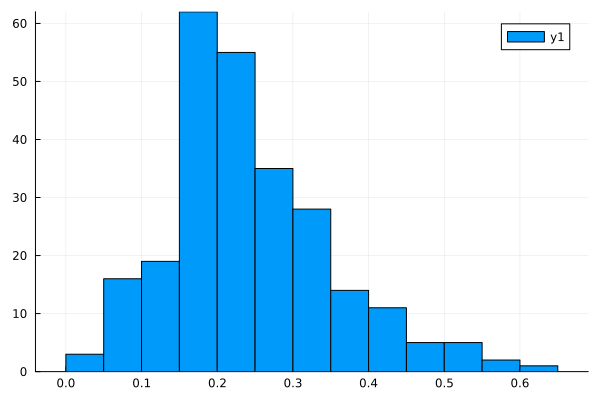

In [307]:
histogram(sin.(pi/4 .* abs.(distances)))

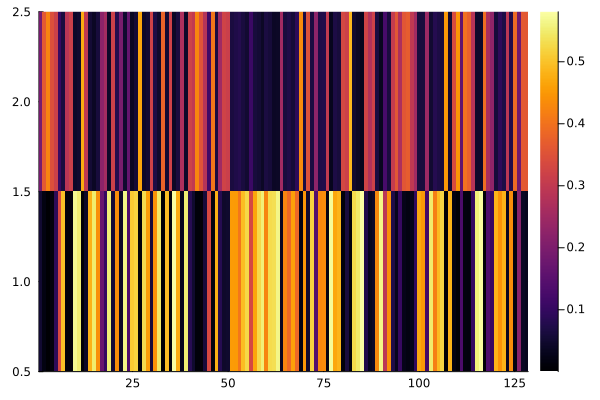

In [308]:
heatmap(abs2.(yhp1) |> cdev)

In [309]:
import .PhasorNetworks: loss_and_accuracy, SpikingTypes, predict_codebook, on_gpu

In [310]:
loss_and_accuracy(test_loader, p_model, ppst, pstp, args)

(0.26835376f0, 0.922)